# Why You Can't Add All Features Into Causal Inference Even With ML
# Part 3 - Reverse causal
Hiro Naito

## Preps

In [4]:
# Libraries 

import pandas as pd
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Gaussian

import dowhy
from dowhy import CausalModel
from dowhy import gcm
import networkx as nx


from lightgbm import LGBMRegressor
from econml.dml import DML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from econml.metalearners import TLearner
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression


In [15]:
def create_graph(causal_matrix: pd.DataFrame): 
    """ Helper function to create an nx graph given a pandas dataframe storing the cause (rows) and effect (in columns)
    """
    G = nx.DiGraph()
    G.add_nodes_from(causal_matrix.columns.to_list())
    for i, row in enumerate(causal_matrix.index):
        for j, col in enumerate(causal_matrix.columns):
            weight = causal_matrix.iloc[i, j]
            if weight != 0.0:  # Add an edge only if the weight is non-zero
                G.add_edge(row, col, weight=weight)

    return G

def create_synth_data(G : nx.DiGraph, causal_matrix: pd.DataFrame, n: int, binaries: list[str] = []):
    """ Helper function to create synthetic data given causal graph + nx graph. 
    """
    #Get list of nodes in topolocial order
    topological_sorted = list(nx.topological_sort(G))

    df = pd.DataFrame()
    for node in topological_sorted:
        if node in binaries:
            values = np.zeros(n)
            for predecessor in G.predecessors(node):
                values += df[predecessor] * causal_matrix.at[predecessor,node]
            p = 1 / (1 + np.exp(-1.0 * values))
            values = np.random.binomial(1,p,n)
        else:
            values = np.random.normal(0,1,n)
            for predecessor in G.predecessors(node):
                values += df[predecessor] * causal_matrix.at[predecessor,node]
        df[node] = values
    return df

In [17]:
#Synthetic data size
n = 100000

#Fixing seed
random_state=123
np.random.seed(123)

### Simple example with a reverse causal
__Example scenarios:__
   * __Employment: New job manual__
      * __Treatment (T):__ New job manual for better productivity
      * __Outcome (Y):__ Productivity
      * __Reverse causal (R):__ Job satisfaction score
      *  __Why is may be reverse:__ You may assume the job satisfaction leads to productivity, but a lot of study finds productivity leads to higher job satisfaction due to better feel of accomplishments and more recognition for work.
   * __Mental Health:__
      * __Treatment (T):__ Joining social support group
      * __Outcome (Y):__ Depression score
      * __Reverse causal (R):__ (Prior) Social isolation level
      *  __Why is may be reverse:__ You may assume a patients social isolation leads to higher depresession score from a survey, but some study finds getting depressed (and therefore, higher depresession score) is the reason people decides or gets isolated from friends and society. 


In [161]:
# Create causal matrix and create graph + synthetic data based on the matrix

#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship
causal_matrix = pd.DataFrame([
    {"node_from": "T", "T": 0.0, "Y": 2.0, "R": 0.0},
    {"node_from": "Y", "T": 0.0, "Y": 0.0, "R": 100.0},
    {"node_from": "R", "T": 0.0, "Y": 0.0, "R": 0.0}
])

causal_matrix.set_index('node_from',inplace=True)

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)

#Create synthetic data with the relationship specified
T = np.random.binomial(1,0.5,n)
Y = 2.0 * T + np.random.normal(0,1,n)
R = 4.0 * Y + np.random.normal(0,1,n)


df = pd.DataFrame({'T':T,'Y':Y,'R':R})
print(df)

       T         Y          R
0      1  0.218096   0.496440
1      1  2.907558  11.183024
2      0 -1.667610  -5.660070
3      1  1.422620   5.083248
4      0 -0.060773  -0.642832
...   ..       ...        ...
99995  1  3.813889  14.641567
99996  1  2.814775  12.030690
99997  1  1.009420   3.489834
99998  0 -1.436588  -4.140953
99999  1  1.877058   6.150396

[100000 rows x 3 columns]


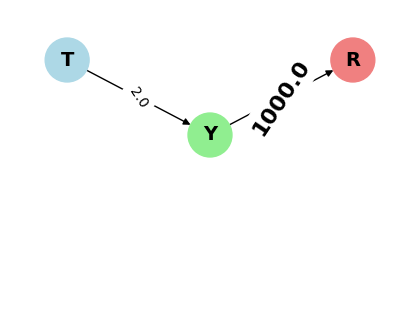

In [179]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'R':(1,0), 'Y':(0.5,-0.3)}
pos = nx.spring_layout(G, k=0.1, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "R" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=14, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos1, edge_labels={('T', 'Y'): "2.0"},font_weight = "normal")
nx.draw_networkx_edge_labels(G, pos1, edge_labels={('R', 'Y'): "1000.0"},font_weight = "bold", font_size=16)



plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

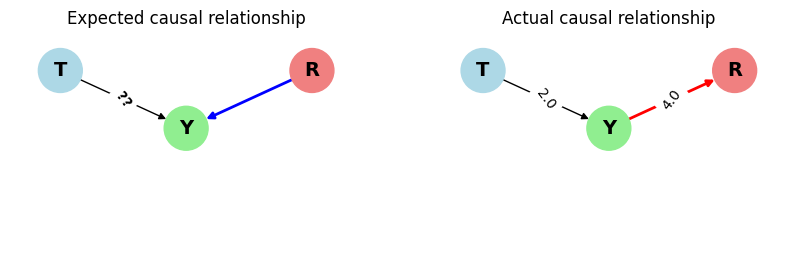

In [153]:
#Graphs for blog post by adding colors to edges 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
G1 = G.copy()

#Remove the existing edges and re-add with colors and fixed labels
G1.remove_edge("Y","R")
G1.add_edge("R","Y",weight=4.0)
pos1 = nx.spring_layout(G1, k=0.1, scale=1, pos=fixed_positions, fixed=fixed_positions.keys())
nx.draw(G1, pos1, with_labels=True, node_size=1000, edge_color=['black','blue'], width= [1,2], node_color=node_colors, font_size=14, font_weight='bold', ax=ax1)
labels = nx.get_edge_attributes(G1, 'weight')
nx.draw_networkx_edge_labels(G1, pos1, edge_labels={('T', 'Y'): "??"},font_weight = "bold", ax=ax1)
nx.draw_networkx_edge_labels(G1, pos1, edge_labels={('R', 'Y'): ""},font_weight = "normal", ax=ax1)


ax1.set_title("Expected causal relationship")
ax1.set_xlim(-0.2, 1.2)  # Add padding around the x-axis
ax1.set_ylim(-1, 0.2)  # Add padding around the y-axis


G2 = G.copy()
pos2 = nx.spring_layout(G2, k=0.1, scale=1, pos=fixed_positions, fixed=fixed_positions.keys())
nx.draw(G2, pos2, with_labels=True, node_size=1000, edge_color=['black','red'], width= [1,2], node_color=node_colors, font_size=14, font_weight='bold', ax=ax2)
labels = nx.get_edge_attributes(G2, 'weight')
nx.draw_networkx_edge_labels(G2, pos2, edge_labels=labels, ax=ax2)
ax2.set_title("Actual causal relationship")
ax2.set_xlim(-0.2, 1.2)  # Add padding around the x-axis
ax2.set_ylim(-1, 0.2)  # Add padding around the y-axis


plt.show()


In [154]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          1.0053
Method:                          IRLS   Log-Likelihood:            -1.4216e+05
Date:                Tue, 01 Oct 2024   Deviance:                   1.0053e+05
Time:                        09:40:47   Pearson chi2:                 1.01e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6348
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0033      0.004     -0.733      0.4

In [157]:
#Estimate effect by regressing on outcome using both treatment and reverse causal variable

formula = 'Y ~ T + R'
glm_model = smf.glm(formula=formula, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99997
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                        0.058483
Method:                          IRLS   Log-Likelihood:                 58.630
Date:                Tue, 01 Oct 2024   Deviance:                       5848.1
Time:                        09:40:48   Pearson chi2:                 5.85e+03
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0009      0.001     -0.825      0.4

### Two reverse causal example
__Example scenarios:__
   * __Marketing: Retail campaign effectiveness__
      * __Treatment (T):__ New marketing campaign for store visit
      * __Outcome (Y):__ Sales
      * __Reverse causal 1 (R1):__ Customer engagement on social media
      * __Reverse causal 2 (R2):__ Customer satisfaction
      * __Why is may be reverse:__ You may assume increase in social media engagement and customer satisfaction leads to higher sales. However since new marketing campaign is for store visits, increase in new store visits and therefore increase in sales may naturally lead to more social media posts and increase in customer satisfaction
   * __Education: Scholarship program__
      * __Treatment (T):__ New student mentoring program
      * __Outcome (Y):__ Academic performance
      * __Reverse causal 1 (R1):__ Parental encouragement
      * __Reverse causal 2 (R2):__ Parent participation to school activities
      * __Why is may be reverse:__ You may assume that parent's encouragement and extracurricular activities leads to higher academic performance. However parental encouragement is much easily done with higher academic performance, and higher academic performance may lead to parents trusting the school leading to more participation in school activities



In [19]:
# Create causal matrix and create graph + synthetic data based on the matrix

#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship
causal_matrix = pd.DataFrame([
    {"node_from": "T", "T": 0.0, "Y": 2.0, "R1": 0.0, "R2": 0.0},
    {"node_from": "Y", "T": 0.0, "Y": 0.0, "R1": 4.0, "R2": 2.0},
    {"node_from": "R1", "T": 0.0, "Y": 0.0, "R1": 0.0, "R2": 3.0},
    {"node_from": "R2", "T": 0.0, "Y": 0.0, "R1": 0.0, "R2": 0.0},

])
causal_matrix.set_index('node_from',inplace=True)

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)

#Define which variables have binary outcome
binaries = ['T']

#Create synthetic data based on graph and causal_matrix
df = create_synth_data(G, causal_matrix, n, binaries)

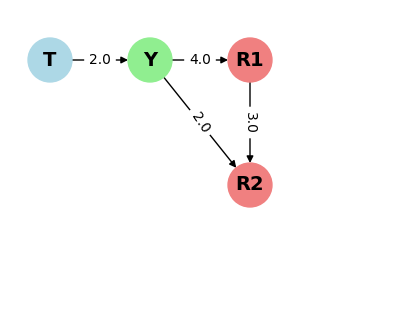

In [21]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'R1':(1,0), 'R2':(1,-0.5), 'Y': (0.5, 0)}
pos = nx.spring_layout(G, k=0.1, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "R" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=14, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


plt.xlim(-0.2, 1.8)  # Add padding around the x-axis
plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

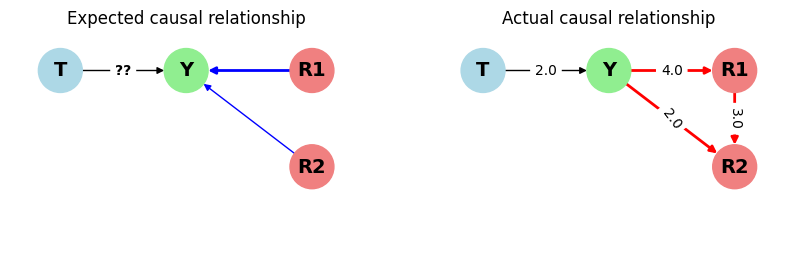

In [22]:
#Graphs for blog post by adding colors to edges 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
G1 = G.copy()

#Remove the existing edges and re-add with colors and fixed labels
G1.remove_edge("Y","R1")
G1.remove_edge("Y","R2")
G1.remove_edge("R1","R2")
G1.add_edge("R1","Y",weight=4.0)
G1.add_edge("R2","Y",weight=4.0)
pos1 = nx.spring_layout(G1, k=0.1, scale=1, pos=fixed_positions, fixed=fixed_positions.keys())
nx.draw(G1, pos1, with_labels=True, node_size=1000, edge_color=['black','blue', 'blue'], width= [1,2], node_color=node_colors, font_size=14, font_weight='bold', ax=ax1)
labels = nx.get_edge_attributes(G1, 'weight')
nx.draw_networkx_edge_labels(G1, pos1, edge_labels={('T', 'Y'): "??"},font_weight = "bold", ax=ax1)
nx.draw_networkx_edge_labels(G1, pos1, edge_labels={('R1', 'Y'): ""},font_weight = "normal", ax=ax1)
nx.draw_networkx_edge_labels(G1, pos1, edge_labels={('R2', 'Y'): ""},font_weight = "normal", ax=ax1)


ax1.set_title("Expected causal relationship")
ax1.set_xlim(-0.2, 1.2)  # Add padding around the x-axis
ax1.set_ylim(-1, 0.2)  # Add padding around the y-axis


G2 = G.copy()
pos2 = nx.spring_layout(G2, k=0.1, scale=1, pos=fixed_positions, fixed=fixed_positions.keys())
nx.draw(G2, pos2, with_labels=True, node_size=1000, edge_color=['black','red','red','red'], width= [1,2,2,2], node_color=node_colors, font_size=14, font_weight='bold', ax=ax2)
labels = nx.get_edge_attributes(G2, 'weight')
nx.draw_networkx_edge_labels(G2, pos2, edge_labels=labels, ax=ax2)
ax2.set_title("Actual causal relationship")
ax2.set_xlim(-0.2, 1.2)  # Add padding around the x-axis
ax2.set_ylim(-1, 0.2)  # Add padding around the y-axis


plt.show()


In [24]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                         0.99526
Method:                          IRLS   Log-Likelihood:            -1.4166e+05
Date:                Thu, 03 Oct 2024   Deviance:                       99524.
Time:                        12:11:12   Pearson chi2:                 9.95e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6347
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.004      0.075      0.9

In [29]:
#Estimate effect by regressing on outcome using both treatment and reverse causal variables

formula1 = 'Y ~ T + R1 + R2'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99996
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                        0.047738
Method:                          IRLS   Log-Likelihood:                 10209.
Date:                Thu, 03 Oct 2024   Deviance:                       4773.6
Time:                        12:11:21   Pearson chi2:                 4.77e+03
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0016      0.001     -1.613      0.1

In [33]:
#Estimate effect by regressing on outcome using both treatment and reverse causal variable

formula1 = 'Y ~ T + R2'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99997
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                        0.048596
Method:                          IRLS   Log-Likelihood:                 9318.8
Date:                Thu, 03 Oct 2024   Deviance:                       4859.4
Time:                        12:11:33   Pearson chi2:                 4.86e+03
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0015      0.001     -1.512      0.1

### Complex example

In [375]:
# Import causal matrix and create graph + synthetic data based on the matrix
causal_matrix = pd.read_csv("Dont add all features - Reverse causal.csv", index_col=0)
causal_matrix.fillna(0.0,inplace=True)
#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)

#Define which variables have binary outcome
binaries = ['T']

#Create synthetic data based on graph and causal_matrix
df = create_synth_data(G, causal_matrix, n, binaries)

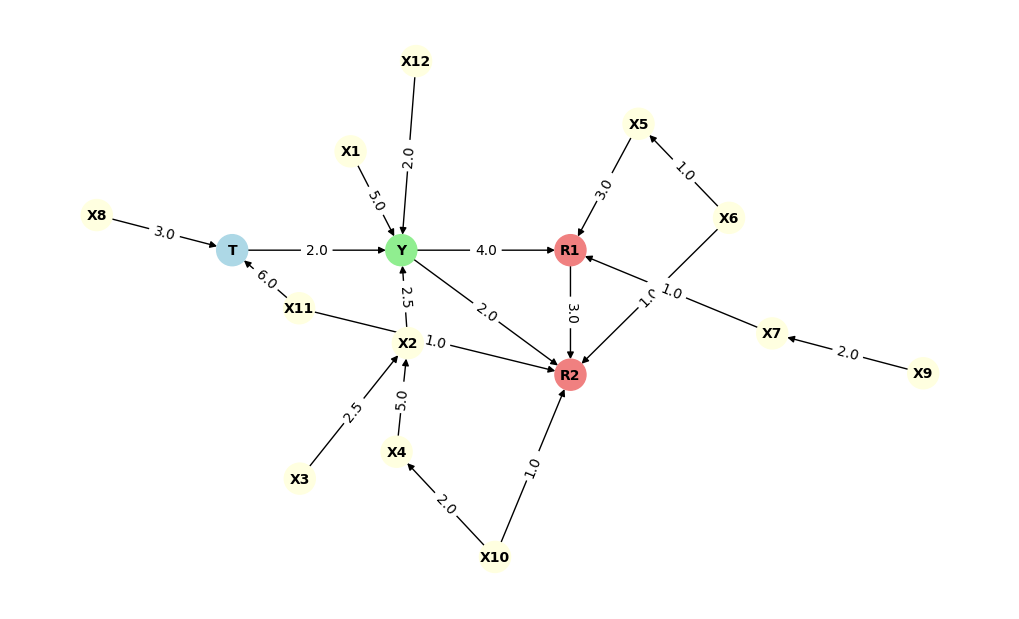

In [348]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'R1':(0.6,0), 'R2':(0.6,-0.2), 'Y': (0.3, 0)}

pos = nx.spring_layout(G, k=0.2, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "R" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(10,6))
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


#plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
#plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [376]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          857.12
Method:                          IRLS   Log-Likelihood:            -4.7957e+05
Date:                Wed, 02 Oct 2024   Deviance:                   8.5710e+07
Time:                        11:18:25   Pearson chi2:                 8.57e+07
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0009932
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1818      0.131      1.388      0.1

In [377]:
#Estimate effect by regressing on outcome using all variables

formula1 = 'Y ~ T + R1 + R2 + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99984
Model Family:                Gaussian   Df Model:                           15
Link Function:               Identity   Scale:                        0.048072
Method:                          IRLS   Log-Likelihood:                 9867.0
Date:                Wed, 02 Oct 2024   Deviance:                       4806.4
Time:                        11:18:26   Pearson chi2:                 4.81e+03
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0007      0.001     -0.511      0.6

In [378]:
#Create train & test data
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(df.drop(columns=['T','Y']), df['T'],df['Y'], test_size=0.2, random_state=random_state)

In [379]:
#Estimate using T-learner and using  light GBM as the underlying model

#Define and train model(s). 
t_learner = TLearner(models = LGBMRegressor(n_estimators=100, random_state=random_state))
t_learner.fit(Y_train, T_train, X=X_train)

#Calculate ITE (Individual Treatment Effect) for the test set
ite = t_learner.effect(X_test)

#Calculate ATE (Average Treatment Effect) by taking the average of the ITEs
cate = np.mean(ite)
print(f"\nEstimated Conditional Average Treatment Effect (ATE): {cate}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 40008, number of used features: 14
[LightGBM] [Info] Start training from score 0.157211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 39992, number of used features: 14
[LightGBM] [Info] Start training from score 2.022516

Estimated Conditional Average Treatment Effect (ATE): -0.0192182084241143


In [386]:
#Estimate using DML and using Random forest the underlying model

#Define DML (Double Machine Learning) setup
dml = DML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_t=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_final=StatsModelsLinearRegression(),
    cv=3,
    random_state=random_state
)

# Fit the DML model
dml.fit(Y_train, T_train, X=X_train)

#Calculate ITE (Individual Treatment Effect) for the test set
ite = dml.effect(X_test)

#Calculate ATE (Average Treatment Effect) by taking the average of the ITEs
cate = np.mean(ite)
print(f"\nEstimated Conditional Average Treatment Effect (ATE): {cate}")


Estimated Conditional Average Treatment Effect (ATE): 0.003892689833916613


The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
